# LastFM Recommendation System - EDA
June [x] 2018  

### Import files and packages

In [1]:
# check kernel (optional)
import sys
sys.executable

'/home/cipher000/anaconda3/envs/ipykernel_py3/bin/python'

In [2]:
# First we import our packages needed for this analysis
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix # compressed Sparse Row matrix
from sklearn.neighbors import NearestNeighbors # use K-Nearest Neighbors to find cosine distance amongst our artists
from fuzzywuzzy import fuzz # fuzzy string matching so we allow for slight misspellings of artist names

# for EDA
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

In [4]:
# Six csv files were provided, but we will only need two for our basic recommender system

# using artists and play count per user
artists = pd.read_csv('../data/artists.dat', sep='\t',usecols=['id','name'])
plays = pd.read_csv('../data/user_artists.dat', sep='\t')

# additional user data,for later analysis
tags = pd.read_csv('../data/tags.dat', sep='\t',encoding='latin-1')
friends = pd.read_csv('../data/user_friends.dat', sep='\t')
utat = pd.read_csv('../data/user_taggedartists-timestamps.dat', sep="\t")
uta = pd.read_csv('../data/user_taggedartists.dat', sep='\t')

### Exploratory Data Analysis (EDA)

Analyze by:
- Timestamp
- Users
- Friends
- Tags
- Artists

In [5]:
# Explore specs of each file provided.  We will only use artists and plays in the basic system.
csv_list = [artists, plays, tags, friends, utat,uta]
csv_names = ['artists', 'plays', 'tags', 'friends', 'user_taggedartists-timestamps','user_taggedartists']
for i in range(len(csv_list)):
    name = csv_names[i]
    shape = csv_list[i].shape
    columns = csv_list[i].columns
    unique = csv_list[i].nunique()
    print("{}\n{}\n{}\n{}\n".format(name, shape, columns,unique))

artists
(17632, 2)
Index(['id', 'name'], dtype='object')
id      17632
name    17632
dtype: int64

plays
(92834, 3)
Index(['userID', 'artistID', 'weight'], dtype='object')
userID       1892
artistID    17632
weight       5436
dtype: int64

tags
(11946, 2)
Index(['tagID', 'tagValue'], dtype='object')
tagID       11946
tagValue    11946
dtype: int64

friends
(25434, 2)
Index(['userID', 'friendID'], dtype='object')
userID      1892
friendID    1892
dtype: int64

user_taggedartists-timestamps
(186479, 4)
Index(['userID', 'artistID', 'tagID', 'timestamp'], dtype='object')
userID        1892
artistID     12523
tagID         9749
timestamp     3549
dtype: int64

user_taggedartists
(186479, 6)
Index(['userID', 'artistID', 'tagID', 'day', 'month', 'year'], dtype='object')
userID       1892
artistID    12523
tagID        9749
day             4
month          12
year           10
dtype: int64



Key features include:
- userID
- friendID
- artistID, Name
- weight (plays by user of artist)
- tagID, tagValue

Temporal:
- timestamp
- day, month, year

### Artists + Plays

In [6]:
# merge artist and play files
artist_plays = pd.merge(artists, plays,how='left',left_on='id',right_on='artistID')

In [7]:
artist_plays.head()

,id,name,userID,artistID,weight
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [8]:
# Obtain total plays by artist
ap2 = (artist_plays.groupby(['name'])['weight'].sum().reset_index().
                rename(columns={'weight':'total_artist_plays','name':'artist_name'})
               [['artist_name','total_artist_plays']])

In [9]:
ap3 = ap2.sort_values(['total_artist_plays'],ascending=False)[:10]

In [10]:
ap3

,artist_name,total_artist_plays
2336,Britney Spears,2393140
3998,Depeche Mode,1301308
8352,Lady Gaga,1291387
3023,Christina Aguilera,1058405
11069,Paramore,963449
9130,Madonna,921198
12072,Rihanna,905423
12818,Shakira,688529
14109,The Beatles,662116
7913,Katy Perry,532545


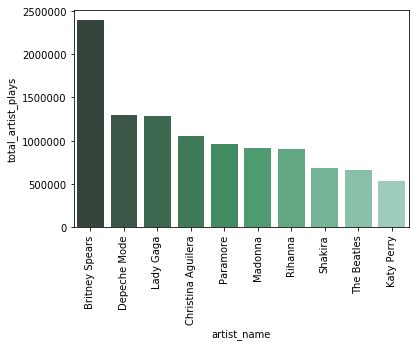

In [11]:
x = ap3.artist_name
y = ap3.total_artist_plays

sns.barplot(x, y, palette="BuGn_d")
plt.xticks(rotation=90)
plt.show()

In [12]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x = ap3.artist_name,
            y = ap3.total_artist_plays
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~cipher813/0 or inside your plot.ly account where it is named 'basic-bar'


### User Data

In [13]:
ud1 = pd.merge(utat,uta,how='outer') # ud = user data
assert len(ud1) == len(uta) == len(utat)

In [14]:
ud1.head()

,userID,artistID,tagID,timestamp,day,month,year
0,2,52,13,1238536800000,1,4,2009
1,2,52,15,1238536800000,1,4,2009
2,2,52,18,1238536800000,1,4,2009
3,2,52,21,1238536800000,1,4,2009
4,2,52,41,1238536800000,1,4,2009


In [15]:
friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [16]:
friends[friends['userID']==3]

,userID,friendID
13,3,78
14,3,255
15,3,460
16,3,837
17,3,1740
18,3,1801
19,3,1975


In [17]:
friends.describe()

,userID,friendID
count,25434.000,25434.000
mean,992.161,992.161
std,603.959,603.959
min,2.000,2.000
25%,441.000,441.000
50%,984.000,984.000
75%,1514.000,1514.000
max,2100.000,2100.000


In [18]:
import networkx as nx

In [19]:
len(friends.userID)

25434

In [20]:
G = nx.Graph()
G.add_nodes_from(friends.userID)

In [21]:
for i in range(len(friends)):
    G.add_edge(friends.userID.iloc[i],friends.friendID.iloc[i])


In [22]:
G.number_of_nodes()

1892

In [23]:
G.number_of_edges()

12717

In [24]:
import igraph as ig

In [25]:
Edges=[(friends.userID.iloc[i],friends.friendID.iloc[i]) for i in range(len(friends))]
Nodes=[(friends.userID.iloc[i],1) for i in range(len(friends))]

In [26]:
labels = []
group = []
for node in Nodes:
    labels.append(node[0])
    group.append(node[1])

In [27]:
G=ig.Graph(Edges,directed=False)

In [28]:
layt=G.layout('kk',dim=3)

In [29]:
layt[5]

[18.21100666637657, -1.8288051790016755, -10.031461668322878]

In [30]:
N = len(layt)
Xn = [layt[k][0] for k in range(N)]
Yn = [layt[k][1] for k in range(N)]
Zn = [layt[k][2] for k in range(N)]
Xe = []
Ye = []
Ze = []

for e in Edges:
    Xe+=[layt[e[0]][0], layt[e[1]][0],None]
    Ye+=[layt[e[0]][1], layt[e[1]][1],None]
    Ze+=[layt[e[0]][2], layt[e[1]][2],None]

In [31]:
import plotly.plotly as py
import plotly.graph_objs as go

In [38]:
trace1=go.Scatter3d(x=Xe,y=Ye,z=Ze,
                    mode='lines',
                    line=dict(color='rgb(125,125,125)',width=1),
                   hoverinfo='none')
trace2=go.Scatter3d(x=Xn,y=Yn,z=Zn,
                    mode='markers',
                    name='actors',
                    marker=dict(symbol='dot',
                                size=6,
                                color=group,
                                colorscale='Viridis',
                                line=dict(color='rgb(125,125,125)',width=0.5)),
                    text=labels,
                    hoverinfo='text')

In [34]:
axis=dict(showbackground=False,
         showline=False,
         zeroline=False,
         showgrid=False,
         showticklabels=False,
         title='')

In [35]:
layout = go.Layout(
            title='LastFM Friend Network',
            width=1000,
            height=1000,
            showlegend=False,
            scene=dict(xaxis=dict(axis),
                      yaxis=dict(axis),
                      zaxis=dict(axis),
                      ),
            margin=dict(t=100),
            hovermode='closest',
            annotations=[dict(showarrow=False,
                 text='Data Source: www.last.fm, courtesy of Lab41/GroupLens',
                 xref='paper',
                 yref='paper',
                 x=0,
                 y=0.1,
                 xanchor='left',
                 yanchor='bottom',
                 font=dict(size=14))],)

In [36]:
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)

py.iplot(fig,filename='LastFM Friend Network')

/home/cipher000/anaconda3/envs/ipykernel_py3/lib/python3.5/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/home/cipher000/anaconda3/envs/ipykernel_py3/lib/python3.5/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, 

The draw time for this plot will be slow for clients without much RAM.


/home/cipher000/anaconda3/envs/ipykernel_py3/lib/python3.5/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [39]:
import plotly.plotly as py
import plotly.graph_objs as go

import networkx as nx

A=nx.Graph()
pos=nx.get_node_attributes(A,'pos')

dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

p=nx.single_source_shortest_path_length(A,ncenter)

NodeNotFound: Source 0 is not in G

In [40]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in A.edges():
    x0, y0 = A.node[edge[0]]['pos']
    x1, y1 = A.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in A.nodes():
    x, y = A.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

In [41]:
for node, adjacencies in enumerate(A.adjacency()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

In [42]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

In [43]:
import plotly.plotly as py
import plotly.graph_objs as go

import networkx as nx

G=nx.random_geometric_graph(200,0.125)
pos=nx.get_node_attributes(G,'pos')

dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

p=nx.single_source_shortest_path_length(G,ncenter)

In [44]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

In [45]:
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

In [46]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

In [ ]:
from graphviz import Graph

In [ ]:
g = Graph('G',filename='process.gv',engine='sfdp')

In [ ]:
for i in range(len(friends)):
    g.edge(str(friends.userID.iloc[i]),str(friends.friendID.iloc[i]))

In [ ]:
g.view()

In [ ]:
ud2 = pd.merge(ud1, friends, how='left',on='userID')

In [ ]:
len(ud1)

In [ ]:
len(ud2)